In [42]:
#%% Packages
import os
import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import mean_squared_error,mean_absolute_error,confusion_matrix,r2_score
from sklearn.preprocessing import MinMaxScaler,PowerTransformer,StandardScaler
from sklearn.model_selection import KFold,train_test_split
pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
import time
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [53]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

# reframe dataset
def reframe(values,hyperparameters,var_names):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_names)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    n_var = len(var_names)
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed


def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose,loss_function):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss=loss_function, optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

def reshape_dataset(train,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y

def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,mae,r2,nutrient,test_time,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(np.concatenate((yhat.reshape(yhat.shape[0],1),
                                        y.reshape(y.shape[0],1)), 
                                       axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}, MAE:{}'.format(round(rmse,2),round(mae,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    ax1[0].legend(frameon=False)
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1,pred_ts

# ensure all data is float
def predict_lstm(values,hyperparameters):
    train_X, train_y = reshape_dataset(values,hyperparameters['time_steps'])
    train_y=Scaler_y.fit_transform(train_y.reshape(-1, 1))
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    MAE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],
                         hyperparameters['verbose'],hyperparameters['loss_function'])
        yhat = Scaler_y.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler_y.inverse_transform(y_test.reshape(-1, 1))
        rmse = mean_squared_error(y_test, yhat,squared=False)
        mae= mean_absolute_error(y_test, yhat)
        r2 =  r2_score(y_test, yhat)
        RMSE.append(rmse) 
        MAE.append(mae)
        R2.append(r2)
        #print('Training RMSE: %.2f' %rmse)       
    print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
    print("Training dataset MAE %.2f (+/- %.2f)" % (np.mean(MAE), np.std(MAE)))
    print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
    return model,RMSE,MAE,R2

def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler_y.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df


In [8]:
os.chdir('..\\clustered training data')

In [23]:
d=pd.read_csv('cluster_17.csv',parse_dates=['date'])
earthquake_families=['BEVERAGES', 'GROCERY I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'PERSONAL CARE', 'PET SUPPLIES']
## Remove the sales of the families that affected by earthquake during Apr - May 2016 
d.drop(d[(d.family.isin(earthquake_families))&(d.date>=pd.Timestamp(2016,4,1))&(d.date<pd.Timestamp(2016,6,1))].index,inplace=True)
d=pd.concat([d,pd.get_dummies(d['family'])],axis=1).drop('family',axis=1)
d = d.drop(['city','state','type','cluster'],axis=1)
d.dropna(inplace=True)
features=[list(d.columns)[i] for i in [2]+list(range(4,len(d.columns)-1))]
target=list(d.columns)[3]
X=d[features]
y=d[target]

<AxesSubplot:xlabel='date', ylabel='sales'>

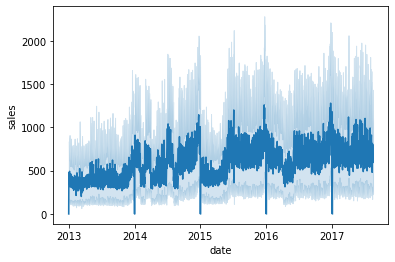

In [45]:
sns.lineplot(data=d,x='date',y='sales')

In [55]:
# set the hyperparameters
hyperparameters = {'n_batch':20,'nb_epoch':20,'n_neuros':50,'dropout':0.2,'time_steps':3,
                   'n_out':1,'verbose':0,'loss_function':'mae'}

In [56]:
df=pd.concat([X,y],axis=1)

In [57]:
Scaler_X = MinMaxScaler()
Scaler_y = MinMaxScaler()#PowerTransformer(standardize=False)
start_time = time.time()
values = df.values
features.append(target)
# frame as supervised learning
reframed = reframe(values,hyperparameters,features)

In [58]:
reframed_scaled=pd.DataFrame(Scaler_X.fit_transform(reframed.iloc[:,:-1]),
                             columns=reframed.columns[:-1])
target_array=pd.Series(reframed.iloc[:,-1].values.reshape(-1, 1).reshape(-1),
             name=reframed.columns[-1])
reframed_scaled=pd.concat([reframed_scaled,target_array],axis=1)
values = reframed_scaled.values

In [59]:
start_time = time.time()
model,RMSE,MAE,R2 = predict_lstm(values,hyperparameters)
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')

(53458, 4, 102) (53458,)
number of input timesteps: 4
number of features: 102
number of samples: 53458
Training dataset RMSE 241.19 (+/- 11.30)
Training dataset MAE 73.31 (+/- 4.97)
Training dataset R2 0.97 (+/- 0.00)
Model takes 68 min to run
